# Song Language and Success in the US Music Industry

A data science project in Python

By Madison Martin

* Note: This project was originally completed in R and has been updated, shortened, and "translated" into Python here.

# Introduction 

This project aims to illustrate the relationship between the language of the lyrics of songs in popular music
in the United States and the song’s success, using data from Spotify and radio plays. It was inspired by
the recent rise in popularity of music sung in non-English languages in the US by artists like BTS, Bad
Bunny, Maluma, Måneskin, and Blackpink.

**Research Question** Does linguistic discrimination (discrimination on the basis of the manner of
speaking or language being spoken) occur in the US popular music industry, as evidenced by
discrepancies in either audience support or industry support?

## Sourcing the data 

In order to address the research question, I chose to source my songs from the pool of popular songs that
have appeared on the Billboard Hot 100 chart, as it has long been an industry standard. A total of 12
consecutive months of chart data were collected (from January 2020 through January 2021), for a total of 5200
songs. The charts and song data were collected directly from Billboard, and included the song’s rank (from
1-100), title, artist, and week dating the chart. In order to measure the success or support of the songs on
two levels, I also collected audience support data (Spotify streams) and industry support data (radio plays).
The Spotify data was sourced directly from Spotify by week (to match the weekly Hot 100 chart), while the
radio play data was sourced from Chartmetric.

### Language of Lyrics 
In order to assess the impact of lyric language on the support a song gets, I coded each song’s lyrics for
language on a word-by-word basis. I started by identifying which songs were likely to have non-English lyrics using the cld3 package in R. However, the accuracy of language identification tools is poor, and is even less accurate
on a singular word basis, so the rest of the coding for word language in each song’s lyrics was done by hand.
For more information, see the appendix.

  * Note: these CSV files already contain the language coding variables along with streaming and radio play
data, as all three sources of data were cleaned and combined previous to this project for brevity and clarity.

# Exploring the data

## Loading and Precleaning

In [68]:
# Load the necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# Load the data 
songs_df = pd.read_csv('songs_all.csv', index_col=0) 

# view the data 
songs_df.head()

,year,bb_date,rank,song,artist,binary,language,total_words,non_e_words,streams,position,spins,radio_rank
0,2020,2020-01-11,1,circles,post malone,0.0,english,314.0,0.0,7932216.0,3.0,7274.0,2.0
1,2020,2020-01-11,2,memories,maroon 5,0.0,english,442.0,0.0,4416365.0,28.0,5926.0,5.0
2,2020,2020-01-11,3,the box,roddy ricch,0.0,english,540.0,3.0,12533419.0,1.0,NaN,NaN
3,2020,2020-01-11,4,someone you loved,lewis capaldi,0.0,english,323.0,0.0,4729716.0,23.0,5324.0,6.0
4,2020,2020-01-11,5,roxanne,arizona zervas,0.0,english,355.0,0.0,9844160.0,2.0,3759.0,12.0


### Data Dictionary 

**year**: year of the radio and spotify chart dates 

**bb_date**: date of the billboard chart (9 days after streaming and spotify charts due to differences in reporting

**rank**: song's rank on the hot 100 for that week, from 1-100 

**song**: song title (simplified for matching purposes)

**artist**: first or main artist of the song (simplified for matching purposes)

**binary**: whether the song's lyrics are predominantly in English (0) or non-English (1) 

**language**: predominant language of the lyrics 

**total_words**: total number of words in the lyrics

**non_e_words**: number of non-English words in the lyrics 

**streams**: number of Spotify streams accrued that week 

**position**: position on the Spotify top 200 streamed songs weekly chart, from 1-200 

**spins**: number of radio plays per week 

**radio_rank**: rank on the Chartmetric chart for that week for most played songs, from 1-500 

In [57]:
# find the minimum of streams and spins 
print(songs_df['streams'].min() - 1) 
print(songs_df['spins'].min() - 1)

1359137.0
203.0


After merging the data, we can see that some songs that were on the hot 100 for the week did not chart either on the radio or on the top spotify streamed songs, so they have NaNs. However, only a small portion (251 songs, or 4.8%) were on the hot 100 but did not chart either on the radio or spotify. 

In order to deal with the missing data, we will replace the missing values with imputation, representing the highest possible value the variables could have had while still not charting. For position and radio rank, this will be the lowest rank - 1 (201 and 501, respectively). For streams and spins, it will be the the minimums of the data set - 1 (1,359,137 and 203, respectively). 

In [36]:
# replace na's for spotify and radio columns 
songs_df['streams'] = songs_df['streams'].fillna(1359137)
songs_df['position'] = songs_df['position'].fillna(201)
songs_df['spins'] = songs_df['spins'].fillna(203)
songs_df['radio_rank'] = songs_df['radio_rank'].fillna(501)

In [37]:
# need to deal with missing data in lyrics columns 
# find na in binary 
print(songs_df[songs_df['total_words'].isnull()])

      year     bb_date  rank                                         song  \
4491  2020  2020-11-14    92                                    stay down   
5114  2021  2021-01-02    15  it's beginning to look a lot like christmas   

          artist  binary language  total_words  non_e_words    streams  \
4491    lil durk     0.0  english          NaN          NaN  1638494.0   
5114  perry como     NaN      NaN          NaN          NaN  1359137.0   

      position  spins  radio_rank  
4491     147.0  203.0       501.0  
5114     201.0  203.0       501.0  


Note: songs with missing lyric data were stay down - lil durk (11/14/20) and its beginning to look a lot like christmas - perry como (01/02/21). 

In [39]:
# replace missing values in these columns 
songs_df['binary'] = songs_df['binary'].fillna(0)
songs_df['language'] = songs_df['language'].fillna('english')
songs_df['total_words'] = songs_df['total_words'].fillna(songs_df['total_words'].mean())
songs_df['non_e_words'] = songs_df['non_e_words'].fillna(0) 

In [59]:
# add percent variable 
songs_df['percent'] = songs_df['non_e_words'] / songs_df['total_words'] * 100

## Summary Statistics and Visualizations

In [60]:
# find the column statistics for streams and spins 
# make new column of streams in millions to better see numbers 
songs_df['mil_stream'] = songs_df['streams'] / 1000000
print(songs_df['mil_stream'].describe())

count    3811.000000
mean        4.096110
std         2.510221
min         1.359138
25%         2.316638
50%         3.415671
75%         5.014948
max        24.966901
Name: mil_stream, dtype: float64


In [61]:
# now radio spins 
print(songs_df['spins'].describe())

count     3733.000000
mean      2762.868470
std       2134.392203
min        204.000000
25%       1326.000000
50%       2237.000000
75%       3523.000000
max      14825.000000
Name: spins, dtype: float64


The average number of weekly Spotify streams for songs on the hot 100 in 2020 was 4.1 million, with the maximum being a whopping 25 million! The average number of radio plays for hot 100 songs in 2020 per week was 2,763, with the maximum being 14,825 and the minimum being a modest 204 spins. 

In [78]:
# find the top streamed songs of the year 
# created aggregated df for streams per song 
song_streams = songs_df.groupby(['song', 'artist'])['mil_stream'].sum().reset_index()

# create top 10 streams df 
top_streams = song_streams.nlargest(10, 'mil_stream')
print(top_streams)

                song         artist  mil_stream
677          the box    roddy ricch  362.698886
82   blinding lights     the weeknd  331.239319
570         rockstar         dababy  322.957438
771     whats poppin    jack harlow  315.656867
389     life is good         future  238.108187
126          circles    post malone  232.745885
88   blueberry faygo      lil mosey  231.192914
213          falling  trevor daniel  217.884546
751              wap        cardi b  196.822905
593           say so       doja cat  183.308778


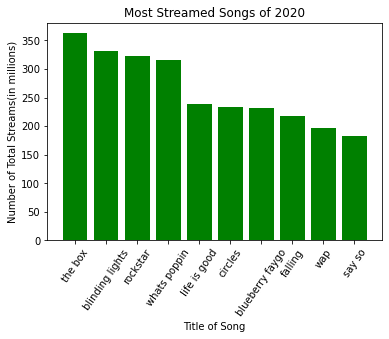

In [79]:
# create viz for top 10 streamed songs 
x = top_streams['song'] 
y = top_streams['mil_stream']

plt.bar(x,y, color="green")
plt.title('Most Streamed Songs of 2020')
plt.xlabel('Title of Song')
plt.ylabel('Number of Total Streams(in millions)')
plt.xticks(rotation=55)
plt.show()

In [80]:
# find the top radio songs of the year 
# created aggregated df for spins per song 
song_spins = songs_df.groupby(['song', 'artist'])['spins'].sum().reset_index()

# create top 10 spins df 
top_spins = song_spins.nlargest(10, 'spins')
print(top_spins)

                song         artist     spins
82   blinding lights     the weeknd  339455.0
570         rockstar         dababy  307035.0
126          circles    post malone  273766.0
12         adore you   harry styles  247669.0
183   dont start now       dua lipa  239517.0
323           i hope  gabby barrett  214068.0
61     before you go  lewis capaldi  178884.0
593           say so       doja cat  175203.0
312  hot girl bummer      blackbear  169648.0
249         go crazy    chris brown  168782.0


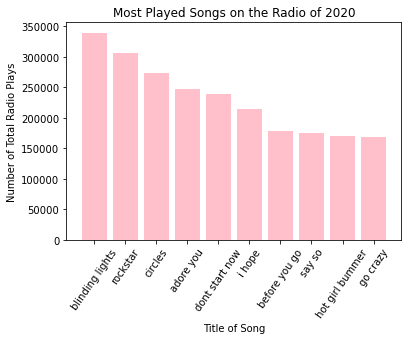

In [81]:
# create viz for top 10 radio songs 
x = top_spins['song'] 
y = top_spins['spins']

plt.bar(x,y, color="pink")
plt.title('Most Played Songs on the Radio of 2020')
plt.xlabel('Title of Song')
plt.ylabel('Number of Total Radio Plays')
plt.xticks(rotation=55)
plt.show()

When looking at the top 10  most streamed and most played songs of 2020 (taken from the hot 100 weekly lists), we can see the songs that had massive success in both industry and audience support included "Blinding Lights" by the Weeknd, "Rockstar" by DaBaby (feat. Roddy Ricch), "Circles" by Post Malone, and "Say So" by Doja Cat. Interestingly, "The Box" by Roddy Ricch was the most streamed song of the year, but was not in the top 10 most radio played songs - a pattern matched by other streaming hits in the rap genre like "WHATS POPPIN" by Jack Harlow and "WAP" by Cardi B and Megan Thee Stallion. Alternatively, country songs like "I Hope" by Gabby Barrett and pop songs like "Adore You" by Harry Styles or "Before You Go" by Lewis Capaldi were radio hits but were not present in the top 10 streaming songs. 

* Please see original R project for more summary statistics about the language variables, visualizations, as well as a full correlation table

# Results - Multiple Linear Regression 

In order to address our research question, multiple linear regression analyses utilizing different combinations of our variables of interest will be conducted to see how a song's lyric language reflects in both audience support (streams) and industry support (radio plays/spins). 

In [41]:
# load the necessary libraries 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  #so we can get nice model summary statistics like original r project 

In [42]:
# are streams influenced by lyric language when controlling for radio plays (spins)? 
## define predictor and response variables
y = songs_df['streams'] 
x = songs_df[['percent', 'spins']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model1 = sm.OLS(y, x).fit()

## view model summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     77.69
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           5.70e-34
Time:                        11:28:28   Log-Likelihood:                -83837.
No. Observations:                5200   AIC:                         1.677e+05
Df Residuals:                    5197   BIC:                         1.677e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.991e+06   4.83e+04     61.895      0.0

Language of lyrics is not significant (p = 0.093) in predicting streams when controlling for radio plays (spins). 

In [43]:
# are radio plays influenced by lyric language when controlling for audience support(streams)? 
## define predictor and response variables
y = songs_df['spins'] 
x = songs_df[['percent', 'streams']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model2 = sm.OLS(y, x).fit()

## view model summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  spins   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     151.1
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.60e-64
Time:                        11:29:10   Log-Likelihood:                -47118.
No. Observations:                5200   AIC:                         9.424e+04
Df Residuals:                    5197   BIC:                         9.426e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1646.9027     49.603     33.201      0.0

Here, langauge of lyrics **is** significant in predicting number of radio plays (spins) when controlling for audience support (streams). It has a negative coefficient, meaning that as the percent of lyrics in non-english langauge increases, the amount of industry support in radio plays decreases. 

In [44]:
# is radio rank influenced by lyric language when controlling for audience support(streams)? 
## define predictor and response variables
y = songs_df['radio_rank'] 
x = songs_df[['percent', 'streams']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model3 = sm.OLS(y, x).fit()

## view model summary
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:             radio_rank   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     222.5
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.93e-93
Time:                        11:29:40   Log-Likelihood:                -34878.
No. Observations:                5200   AIC:                         6.976e+04
Df Residuals:                    5197   BIC:                         6.978e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        160.5962      4.713     34.078      0.0

Our previous finding holds when analyzing the ranking on the radio play chart instead of number of radio plays per week. Lyric language percent is still significant, and the coefficient is positive. That is, as the percentage of non-english lyrics in a song goes up, radio rank gets larger (goes down), when controlling for audience support in spotify streams. 

In [45]:
# is radio rank influenced by lyric language when controlling for audience support(spotify chart position)? 
## define predictor and response variables
y = songs_df['radio_rank'] 
x = songs_df[['percent', 'position']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model4 = sm.OLS(y, x).fit()

## view model summary
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:             radio_rank   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     281.9
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          5.80e-117
Time:                        11:30:38   Log-Likelihood:                -34824.
No. Observations:                5200   AIC:                         6.965e+04
Df Residuals:                    5197   BIC:                         6.967e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.2651      4.400     50.511      0.0

In [46]:
# are radio plays influenced by lyric language when controlling for audience support(spotify chart position)? 
## define predictor and response variables
y = songs_df['spins'] 
x = songs_df[['percent', 'position']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model5 = sm.OLS(y, x).fit()

## view model summary
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                  spins   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     118.6
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           4.35e-51
Time:                        11:31:13   Log-Likelihood:                -47149.
No. Observations:                5200   AIC:                         9.430e+04
Df Residuals:                    5197   BIC:                         9.432e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2442.1692     47.082     51.871      0.0

Our findings also hold for the last two models. We tested all possible combinations of the radio play and streaming variables as predictors and responses. Interestingly, the model with the highest explained variance is model 4, where 9.8% (R-squared = 0.098) of the variance in radio rank can be explained by the two predictor variables. Let's expand upon that model in the following analysis. 

In [47]:
# is radio rank influenced by lyric languge and speechiness(total words) when controlling for audience support(spotify chart position)? 
## define predictor and response variables
y = songs_df['radio_rank'] 
x = songs_df[['percent', 'position', 'total_words']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model6 = sm.OLS(y, x).fit()

## view model summary
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:             radio_rank   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     253.5
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          1.56e-153
Time:                        11:33:20   Log-Likelihood:                -34736.
No. Observations:                5200   AIC:                         6.948e+04
Df Residuals:                    5196   BIC:                         6.951e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         120.2699      8.794     13.677      

In [48]:
# are radio plays influenced by lyric languge and speechiness(total words) when controlling for audience support(spotify streams)? 
## define predictor and response variables
y = songs_df['spins'] 
x = songs_df[['percent', 'streams', 'total_words']]

## add constant
x = sm.add_constant(x)

## fit linear regression model
model7 = sm.OLS(y, x).fit()

## view model summary
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                  spins   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     126.6
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           3.73e-79
Time:                        11:36:39   Log-Likelihood:                -47081.
No. Observations:                5200   AIC:                         9.417e+04
Df Residuals:                    5196   BIC:                         9.420e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2259.4533     86.836     26.020      

When adding the only other non-confounding variable in this dataset as a predictor variable (total words in the lyrics, which can be thought of as similar to the "speechiness" attribute from the now-depreciated spotify api), lyric language continues to have a significant effect on radio support when controlling for audience support (Spotify). The model with the highest explained variance (R-squared = 0.128) was model 6. This amount (12.8%) of explained variance is relatively low, which is to be expected in such a complex issue (how much radio play or audience support a song gets), especially considering this data set did not include any audio-based data which can influence popularity and success like genre, tempo, key, etc.The models from our last two analyses can be presented below: 

**Radio Plays (spins)** = 2259.45 - 19.96 **Percent** + 0.0001 **Streams** - 1.49 **Total Words**

**Radio Rank** = 120.27 + 3.24 **Percent** - 0.35 **Spotify position** + 0.22 **Total Words**

**Main finding**: For every percent of song lyrics that include non-english words, a song is predicted to recieve 19 less radio plays per week, when controlling for audience support in the form of position on the weekly Spotify top 200 streamed songs. Or, for every percent of a song's lyrics that are non-english words, a song is predicted to decrese 3 rankings in the weekly top 500 most played songs on the radio, when controlling for audinece support in the form of Spotify streams. 

## Conclusion 

## Language and Industry Support

When controlling for audience support or preference, as evidenced by Spotify streams per week, there was
a bias against songs which included non-English language lyrics as seen in the number of radio plays
per week. Specifically, the multiple linear regression analysis demonstrates that for this set of data, which
spanned from January 2020 to January 2021, songs were assumed to have 19 fewer radio plays per week for every
percent increase in non-English language included in the lyrics. This industry bias against radio streams becomes especially meaningful when considering that this data set only included songs which had reached a very high level of success in the industry, as being on the Billboard Hot 100, and that the average radio spins per week to be on the Top 500 Airplay Chartmetric chart was only 2,763.

This disparity between the radio plays per week and audience support by streaming for songs with non-
English lyrics clearly demonstrates the presence of an industry bias against non-English songs or artists,
as the music industry is heavily involved in choosing what songs are played during radio programs. While
radio stations do want to entice and keep listeners by playing music they are interested in, they also have
to balance this desire with the drive to promote new music and support industry-backed artists which are
being promoted to individual radio stations by music label promotion representatives (Knab, 2010). A
string of lawsuits in the early 2000’s against these “pay-for-play” practices have not stopped the process of
industry bias and corruption in radio, instead driving the industry to invent new and clever ways to influence
radio towards any direction they prefer (Leight, 2019). This finding replicates earlier studies which have
found industry bias based on performer attributes, such as race and gender, and expands upon the idea
of a discriminatory music industry ecosystem by including linguistic discrimination (Lafrance, Worcester &
Burns, 2011; Strong & Raine, 2018; Watson, 2019; Lafrance et al., 2017; Laybourn, 2018).


## Limitations and Future Directions


There were a few main limitations in this study. Firstly, the sample size of the data was limited by the lack
of accurate programming solution to coding modern music lyrics on a singular word-based level, as many
lyrics include complicated slang and code-switching which are not reliably marked by traditional spelling-
check based methods (Barman et al., 2014). That, in addition to the limited access to high-quality data for
the radio play data from Chartmetric, did not allow a large enough sample size to see a broader vision of
trends in language composition of popular music. Secondly, the scope of the current study did not allow for
inclusion of potential influences on music popularity other than audience support, which is most likely the
reason the explained variance for the multiple linear regression model, although still statistically significant,
is a small effect size (12.8%). This is understandable, as song characteristics (such as tempo, key, melodic
content, and rhythmic patterns), artist characteristics (such as gender, race, age, overall popularity), and
song success measures not included in this analysis (sales, YouTube streams, TikTok plays, etc.), along with
the other features that have been shown in previous studies to impact song success are most likely producing
much of the unexplained variance here (Cosimato et al., 2019; McAuslan & Waung 2018; Napier & Shameer
2018; Nunes & Ordanini, 2014; Ordanini, Nunes & Nanni, 2018).

In order to address these questions and expand upon this study, future research could create a specific
language identification function or dictionary that accurately reflects current popular music lyrical contents,
and include many more possible sources of variation in song success as evidenced by audience and radio
support in order to better assess the presence and strength of linguistic bias in the industry.

# Appendix 

## Language Coding
*Below is a direct excerpt from the original project paper* 

The data set of popular songs sourced from the Billboard Hot 100 were then coded for language by analyzing
the lyrical compositions of the songs. The lyrics for each song were taken from official sources (like Apple
Music or Spotify, which is often powered by Genius) using web scraping methods. If the lyrics for a song were
not available there, they were taken from one of two trusted websites (Lyrics.com or AZLyrics.com). First,
in order to flag the songs that included multiple languages, a language identification function in R (package
cld3) was used to analyze each song’s lyrics to see if it included more than one language, or a single language
other than English. Then, for each song that was flagged, the total word count of the lyrics was recorded,
as well as the total number of non-English words in the lyrics. Finally, the percentage of non-English lyrics
(proportion of non-English words to the total words in the lyrics) was calculated. It is worth noting that
the accuracy of the language identification function in R was lower than expected, so some songs that were
not originally flagged as potential non-English language songs had to be re-coded and analyzed by hand, in
addition to the ones that were flagged.

During the lyric analysis, proper nouns (like names and places) were not considered non-English, unless they
were the foreign-language equivalent (example: Barcelona was not marked, but Estados Unidos was marked
as non-English). Additionally, names of designers and brands were not included, although it is interesting to
note that they appeared frequently in the lyric corpus (examples: Gucci, Prada, Louis Vuitton, Lamborghini,
etc.). Finally, words or slang that were originally from another language but have been inculcated into the
daily vernacular of English speakers in the United States(examples: chardonnay or piñata)were not included
in the non-English language count.

Alternatively, words that might be considered well-known in some sectors of the United States, but have
direct replacements in the English language were counted as non-English (example: cerveza, which is the
Spanish word for beer). In a similar fashion, words that could be considered slang here but were not deemed
to be ubiquitous and are sourced from or directly borrowed from a non-English language were counted as
non-English (example: fuego, which is the Spanish word for fire, which itself is a current slang term in
English). Finally, words that originated in English but were being spoken in the middle of a non-English
phrase, possibly with an accent to make them understandable to native speakers, were considered to be
non-English.

While Billboard itself does not have an official definition of what songs are considered “predominantly non-
English”, following the examples of other media giants such as the Grammy’s and the Oscar’s, the songs
were additionally coded in a binary based on whether they were majority (50% or more) non-English (1)
or not (0) (Oscars, 2021, p. 19;Grammys, 2020, p. 53). Finally, the songs were coded for the language that
made up the majority (50% or more) of their lyrics, like Korean, Spanish, English, etc.